In [1]:
# IMPORTS Y CONFIGURACIÓN

import pandas as pd                      # Manejo de DataFrames (tabla de datos)
import numpy as np                       # Cálculo numérico y simulación aleatoria
import matplotlib.pyplot as plt          # Gráficos

from sklearn.cluster import KMeans       # Algoritmo K-means
from sklearn.preprocessing import StandardScaler, RobustScaler  # Escaladores
from sklearn.metrics import (
    silhouette_score,                    # Métrica silhouette
    davies_bouldin_score,                # Davies-Bouldin (más bajo es mejor)
    calinski_harabasz_score              # Calinski-Harabasz (más alto es mejor)
)

from sklearn.decomposition import PCA    # Para visualizar en 2D con muchas variables
from sklearn.metrics import adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')        # Para no ensuciar salida con warnings

np.random.seed(42)                       # Reproducibilidad: mismo “azar” cada corrida

from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
#/content/drive/MyDrive/datos_ML_no_supervisado/clientes_ecommerce.csv

# B) CARGA DE DATOS (CSV ADJUNTO)

# Ruta del archivo
#/content/clientes_ecommerce2.csv
#/content/clientes_ecommerce.csv
path = "/content/drive/MyDrive/datos_ML_no_supervisado/clientes_ecommerce.csv"
clientes = pd.read_csv(path)

# Resumen general
print("=== Resumen del dataset ===")
print(f"- Shape (filas, columnas): {clientes.shape}")
print(f"- Número de filas: {clientes.shape[0]}")
print(f"- Número de columnas: {clientes.shape[1]}")


# Vista previa de los datos
print("\n=== Primeras filas del dataset ===")
display(clientes.head(10))



=== Resumen del dataset ===
- Shape (filas, columnas): (1500, 18)
- Número de filas: 1500
- Número de columnas: 18

=== Primeras filas del dataset ===


Perfil_latente  Pedidos_mensuales  Gasto_promedio  Tiempo_promedio_entrega  \
0         Basico                  4        9.292250                65.683951   
1         Basico                  1        8.779344                42.664672   
2         Basico                  3        8.395730                35.215317   
3         Basico                  3       10.884914                36.731210   
4         Basico                  1        5.508227                61.842152   
5         Basico                  2       13.842819                38.931827   
6         Basico                  1        8.003733                38.500365   
7         Basico                  1       12.165710                37.236337   
8         Basico                  2        6.190004                50.143530   
9         Basico                  2       12.006520                42.046806   

   Variedad_productos  Gasto_mensual_aprox  Indice_experiencia_logistica  \
0                   1            37.169002                      0.018454   
1                   4             8.779344                      0.023524   
2                   2            25.187190                      0.025596   
3                   3            32.654743                      0.033363   
4                   1             5.508227                      0.020856   
5                   4            27.685637                      0.029177   
6                   2             8.003733                      0.027791   
7                   1            12.165710                      0.025417   
8                   1            12.380008                      0.020798   
9                   3            24.013041                      0.022288   

      Region   Canal    Metodo_pago  Edad Segmento_edad  Antiguedad_meses  \
0  Provincia  Tienda  Transferencia    32         26-35                20   
1  Provincia  Tienda  Transferencia    40         36-50                 1   
2       Lima     Web      Billetera    25         18-25                14   
3  Provincia     Web      Billetera    34         26-35                20   
4  Provincia  Tienda       Efectivo    49         36-50                14   
5       Lima  Tienda       Efectivo    38         36-50                 9   
6       Lima     Web      Billetera    22         18-25                12   
7       Lima     Web  Transferencia    30         26-35                 6   
8  Provincia     Web      Billetera    36         36-50                 9   
9       Lima     Web      Billetera    34         26-35                 7   

   Satisfaccion_1a5  Tuvo_devolucion Nivel_fidelidad Riesgo_churn  Suscripcion  
0                 1                1           Plata         Alto            0  
1                 1                1          Bronce         Alto            0  
2                 3                0           Plata        Medio            0  
3                 1                1           Plata         Alto            0  
4                 1                0          Bronce         Alto            0  
5                 1                1          Bronce         Alto            0  
6                 2                1          Bronce         Alto            0  
7                 2                0          Bronce        Medio            0  
8                 1                1          Bronce         Alto            0  
9                 1                1          Bronce         Alto            0

#  Diccionario de Variables (Data Dictionary)

## 🔹 Variables de Referencia
- **Perfil_latente** → *Categórica nominal*.  
  Se usa solo como referencia conceptual, no debe incluirse en clustering.

---

##  Variables Numéricas
- **Pedidos_mensuales** → *Numérica discreta*. Conteo de pedidos realizados en un mes.  
- **Gasto_promedio** → *Numérica continua*. Promedio de gasto por pedido, admite decimales.  
- **Tiempo_promedio_entrega** → *Numérica continua*. Tiempo medio de entrega en horas o días.  
- **Variedad_productos** → *Numérica discreta*. Número de categorías de productos adquiridos.  
- **Gasto_mensual_aprox** → *Numérica continua*. Estimación del gasto total mensual.  
- **Indice_experiencia_logistica** → *Numérica continua*. Índice que resume la calidad logística.  
- **Edad** → *Numérica discreta*. Edad del cliente en años completos.  
- **Antiguedad_meses** → *Numérica discreta*. Tiempo de relación con la empresa en meses.

---

##  Variables Categóricas Nominales
- **Region** → *Categórica nominal*. Ubicación geográfica del cliente.  
- **Canal** → *Categórica nominal*. Canal de compra (ejemplo: online, presencial).  
- **Metodo_pago** → *Categórica nominal*. Medio de pago utilizado (ejemplo: tarjeta, efectivo).

---

##  Variables Categóricas Ordinales
- **Segmento_edad** → *Categórica ordinal*. Rangos de edad con orden lógico (joven, adulto, mayor).  
- **Nivel_fidelidad** → *Categórica ordinal*. Grado de fidelidad del cliente (bajo, medio, alto).  
- **Riesgo_churn** → *Categórica ordinal*. Nivel de riesgo de abandono (bajo, medio, alto).  
- **Satisfaccion_1a5** → *Ordinal numérica*. Escala de satisfacción de 1 a 5.

---

##  Variables Binarias
- **Tuvo_devolucion** → *Binaria*. Indica si el cliente realizó devoluciones (0 = no, 1 = sí).  
- **Suscripcion** → *Binaria*. Señala si el cliente tiene suscripción activa (0 = no, 1 = sí).

In [ ]:
# F) PREPROCESAMIENTO PARA K-MEANS
# ==========================================
# Idea: K-Means usa distancia euclídea, por eso:
# (1) ordinal -> números respetando orden
# (2) nominal -> one-hot
# (3) numéricas -> escalamiento (para no dominar por magnitud)

# 1) Columnas por tipo (ajustado al CSV real)
num_cols = [
    'Pedidos_mensuales', 'Gasto_promedio', 'Tiempo_promedio_entrega', 'Variedad_productos',
    'Gasto_mensual_aprox', 'Indice_experiencia_logistica', 'Edad', 'Antiguedad_meses',
    'Tuvo_devolucion', 'Suscripcion'   # binarias como numéricas (0/1)
]

nominal_cols = ['Region', 'Canal', 'Metodo_pago']  # sin orden

ordinal_cols = ['Segmento_edad', 'Nivel_fidelidad', 'Riesgo_churn', 'Satisfaccion_1a5']  # con orden

# Chequeo mínimo de columnas esperadas
needed = set(num_cols + nominal_cols + ordinal_cols)
missing = [c for c in needed if c not in clientes.columns]
if missing:
    raise ValueError(f"Faltan columnas en el CSV: {missing}")


# 2) Mapeos ordinales (respetan orden real)
# Segmento_edad: 18-25 < 26-35 < 36-50 < 51+
map_segmento_edad = {'18-25': 0, '26-35': 1, '36-50': 2, '51+': 3}

# Nivel_fidelidad: Bronce < Plata < Oro < Platino
map_fidelidad     = {'Bronce': 0, 'Plata': 1, 'Oro': 2, 'Platino': 3}

# Riesgo_churn: Bajo < Medio < Alto
map_riesgo        = {'Bajo': 0, 'Medio': 1, 'Alto': 2}

clientes['Segmento_edad_ord']   = clientes['Segmento_edad'].astype(str).map(map_segmento_edad)
clientes['Nivel_fidelidad_ord'] = clientes['Nivel_fidelidad'].astype(str).map(map_fidelidad)
clientes['Riesgo_churn_ord']    = clientes['Riesgo_churn'].astype(str).map(map_riesgo)

# 3) Matriz ordinal final
# Satisfaccion_1a5 ya es 1..5 (ordinal numérica)
ord_df = clientes[['Segmento_edad_ord', 'Nivel_fidelidad_ord', 'Riesgo_churn_ord', 'Satisfaccion_1a5']].copy()

# 4) One-hot para nominales
# Convierte categorías en columnas 0/1 (indicadores)
nom_df = pd.get_dummies(clientes[nominal_cols], drop_first=False)

# 5) Numéricas (incluye binarias)
num_df = clientes[num_cols].copy()

# 6) Escalamiento
# RobustScaler: z = (x - mediana) / IQR   (IQR=Q3-Q1)
# Es preferible si hay outliers o colas largas.
scaler = RobustScaler()

num_ord_scaled = scaler.fit_transform(pd.concat([num_df, ord_df], axis=1))

# 7) Reconstruimos DataFrame escalado (mantener nombres)
num_ord_cols = list(num_df.columns) + list(ord_df.columns)
num_ord_scaled_df = pd.DataFrame(num_ord_scaled, columns=num_ord_cols, index=clientes.index)

# 8) Matriz final para clustering
X = pd.concat([num_ord_scaled_df, nom_df], axis=1)

print("\nDimensión final X (para clustering):", X.shape)


Dimensión final X (para clustering): (1500, 23)


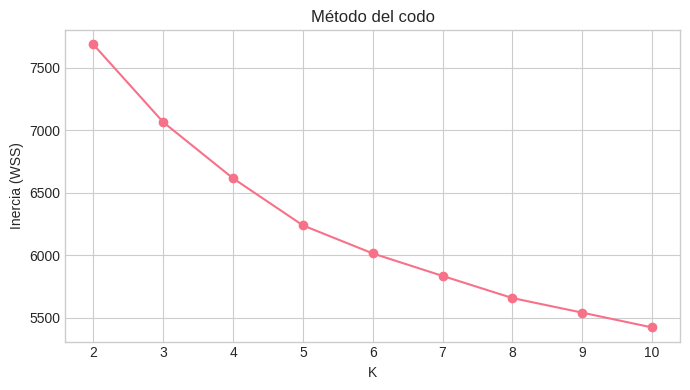

In [ ]:
# G) ELECCIÓN DE K (CODO + MÉTRICAS)
# ==========================================
# - Inercia (WSS): sum_i ||x_i - mu_{c(i)}||^2
# - Silhouette: más alto = mejor
# - Davies-Bouldin: más bajo = mejor
# - Calinski-Harabasz: más alto = mejor

ks = range(2, 11)
inertia = []
sil = []
db = []
ch = []

# Nota: silhouette puede ser más costoso (usa distancias entre puntos).
# Si te tarda mucho, se puede muestrear X para silhouette (te lo adapto si quieres).

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)

    inertia.append(km.inertia_)
    sil.append(silhouette_score(X, labels))
    db.append(davies_bouldin_score(X, labels))
    ch.append(calinski_harabasz_score(X, labels))

# (1) Codo (Inercia)
plt.figure(figsize=(7,4))
plt.plot(list(ks), inertia, marker='o')
plt.xlabel('K')
plt.ylabel('Inercia (WSS)')
plt.title('Método del codo')
plt.tight_layout()
plt.show()

In [ ]:
# H) K-MEANS FINAL + VISUALIZACIÓN CON CENTROIDES
# ==========================================
# Aquí fijamos K (puedes ajustarlo según codo + métricas).
K = 4
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
clientes['Cluster'] = kmeans.fit_predict(X)

print("\nTamaño por cluster:")
print(clientes['Cluster'].value_counts().sort_index())


Tamaño por cluster:
Cluster
0    323
1    537
2    350
3    290
Name: count, dtype: int64


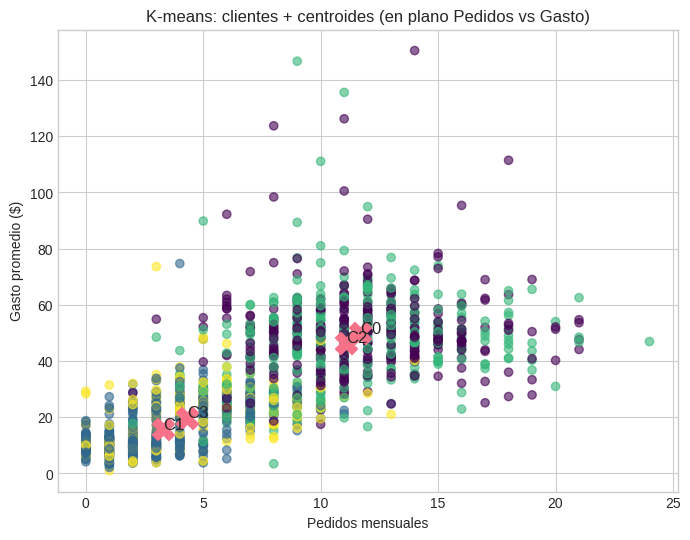

In [ ]:
# H) VISUALIZACIÓN CON CENTROIDES

# --- (1) Scatter en plano original + centroides (promedio en el plano) ---
plt.figure(figsize=(8,6))
plt.scatter(
    clientes['Pedidos_mensuales'],
    clientes['Gasto_promedio'],
    c=clientes['Cluster'],
    cmap='viridis',
    alpha=0.6
)

# Centroides en el plano (Pedidos, Gasto) como promedios por cluster
cent_2d = clientes.groupby('Cluster')[['Pedidos_mensuales', 'Gasto_promedio']].mean()

plt.scatter(
    cent_2d['Pedidos_mensuales'],
    cent_2d['Gasto_promedio'],
    marker='X',
    s=250
)

for k in cent_2d.index:
    plt.text(
        cent_2d.loc[k, 'Pedidos_mensuales'],
        cent_2d.loc[k, 'Gasto_promedio'],
        f"C{k}",
        fontsize=12
    )

plt.xlabel('Pedidos mensuales')
plt.ylabel('Gasto promedio ($)')
plt.title('K-means: clientes + centroides (en plano Pedidos vs Gasto)')
plt.show()

# Mejorando el Modelo Usual de K-means

In [ ]:

# K-MEANS PARA PERFILADO DE CLIENTES (E-COMMERCE)
# 0) CONFIGURACIÓN GENERAL

CSV_PATH = "/content/drive/MyDrive/datos_ML_no_supervisado/clientes_ecommerce.csv"   # <--- AJUSTA ESTA RUTA
RANDOM_STATE = 52

# Rango de K a evaluar (evita K=1 porque silhouette no aplica bien)
K_MIN, K_MAX = 2, 10

# Para silhouette y GAP usamos muestreo (más rápido y suficiente como diagnóstico)
SAMPLE_SIZE_SILH = 600     # si tu dataset crece, baja esto
SAMPLE_SIZE_GAP  = 600

# Gap Statistic: número de datasets de referencia (B)
# (Más B = más estable, pero más costoso)
GAP_B = 10

# Bootstrap stability: cuántos re-muestreos para evaluar estabilidad del clustering
BOOT_B = 15
BOOT_FRAC = 0.8

# Estrategia de escalamiento (ver notas: escalar puede ocultar estructura en algunos casos)
# "robust" (mediana/IQR), "standard" (media/std), "none" (sin escalado)
SCALING_STRATEGY = "robust"

# Peso por grupos para nominales (one-hot):
# True = cada variable nominal (Region/Canal/Metodo_pago) aporta parecido aunque tenga muchas dummies
GROUP_WEIGHT_ONEHOT = True


In [ ]:
# 1) IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')

np.random.seed(RANDOM_STATE)


# -----------------------------
# 2) CARGA + CHEQUEOS BÁSICOS
# -----------------------------
clientes = pd.read_csv(CSV_PATH)

print("=== Resumen del dataset ===")
print(f"- Filas: {clientes.shape[0]}")
print(f"- Columnas: {clientes.shape[1]}")
print(f"- Columnas: {clientes.columns.tolist()}")
display(clientes.head(5))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Resumen del dataset ===
- Filas: 1500
- Columnas: 18
- Columnas: ['Perfil_latente', 'Pedidos_mensuales', 'Gasto_promedio', 'Tiempo_promedio_entrega', 'Variedad_productos', 'Gasto_mensual_aprox', 'Indice_experiencia_logistica', 'Region', 'Canal', 'Metodo_pago', 'Edad', 'Segmento_edad', 'Antiguedad_meses', 'Satisfaccion_1a5', 'Tuvo_devolucion', 'Nivel_fidelidad', 'Riesgo_churn', 'Suscripcion']


Perfil_latente  Pedidos_mensuales  Gasto_promedio  Tiempo_promedio_entrega  \
0         Basico                  4        9.292250                65.683951   
1         Basico                  1        8.779344                42.664672   
2         Basico                  3        8.395730                35.215317   
3         Basico                  3       10.884914                36.731210   
4         Basico                  1        5.508227                61.842152   

   Variedad_productos  Gasto_mensual_aprox  Indice_experiencia_logistica  \
0                   1            37.169002                      0.018454   
1                   4             8.779344                      0.023524   
2                   2            25.187190                      0.025596   
3                   3            32.654743                      0.033363   
4                   1             5.508227                      0.020856   

      Region   Canal    Metodo_pago  Edad Segmento_edad  Antiguedad_meses  \
0  Provincia  Tienda  Transferencia    32         26-35                20   
1  Provincia  Tienda  Transferencia    40         36-50                 1   
2       Lima     Web      Billetera    25         18-25                14   
3  Provincia     Web      Billetera    34         26-35                20   
4  Provincia  Tienda       Efectivo    49         36-50                14   

   Satisfaccion_1a5  Tuvo_devolucion Nivel_fidelidad Riesgo_churn  Suscripcion  
0                 1                1           Plata         Alto            0  
1                 1                1          Bronce         Alto            0  
2                 3                0           Plata        Medio            0  
3                 1                1           Plata         Alto            0  
4                 1                0          Bronce         Alto            0

In [ ]:
# 3) DICCIONARIO DE VARIABLES (TIPOS) -> DEFINIMOS COLUMNAS

# Variable de referencia conceptual (NO entra al clustering)
REF_COL = "Perfil_latente"  # opcional para validar contra “verdad” conceptual

# Numéricas (incluye binarias 0/1)
num_cols = [
    "Pedidos_mensuales",
    "Gasto_promedio",
    "Tiempo_promedio_entrega",
    "Variedad_productos",
    "Gasto_mensual_aprox",
    "Indice_experiencia_logistica",
    "Edad",
    "Antiguedad_meses",
    "Tuvo_devolucion",   # binaria
    "Suscripcion"        # binaria
]

# Nominales (sin orden) -> one-hot
nominal_cols = ["Region", "Canal", "Metodo_pago"]

# Ordinales (con orden lógico) -> mapeo a enteros
ordinal_cols = ["Segmento_edad", "Nivel_fidelidad", "Riesgo_churn", "Satisfaccion_1a5"]

# Chequeo mínimo de columnas esperadas (columnas faltantes)
needed = set(num_cols + nominal_cols + ordinal_cols + [REF_COL])
missing = [c for c in needed if c not in clientes.columns]
if missing:
    raise ValueError(f"Faltan columnas en el CSV: {missing}")
# genera una falla temprana (mejor que obtener clusters “raros” por columnas ausentes)

In [ ]:
# 4) LIMPIEZA / TIPOS / FALTANTES

# 4.1) Aseguramos que binarias sean 0/1 enteros
for b in ["Tuvo_devolucion", "Suscripcion"]:
    clientes[b] = clientes[b].astype(int)

# 4.2) Satisfacción debe ser ordinal numérica (1..5)
clientes["Satisfaccion_1a5"] = clientes["Satisfaccion_1a5"].astype(int)

# 4.3) Manejo de faltantes (si existieran):
# - numéricas: mediana
# - categóricas: moda
for c in num_cols:
    if clientes[c].isna().any():
        clientes[c] = clientes[c].fillna(clientes[c].median())

for c in nominal_cols + ["Segmento_edad", "Nivel_fidelidad", "Riesgo_churn"]:
    if clientes[c].isna().any():
        clientes[c] = clientes[c].fillna(clientes[c].mode().iloc[0])

In [ ]:
# 5) ORDINALES -> MAPEO CON ORDEN REAL
# se asignan un número a cada categoría, respetando el orden real

# Segmento_edad: 18-25 < 26-35 < 36-50 < 51+
map_segmento_edad = {"18-25": 0, "26-35": 1, "36-50": 2, "51+": 3}

# Nivel_fidelidad: Bronce < Plata < Oro < Platino
map_fidelidad = {"Bronce": 0, "Plata": 1, "Oro": 2, "Platino": 3}

# Riesgo_churn: Bajo < Medio < Alto
map_riesgo = {"Bajo": 0, "Medio": 1, "Alto": 2}

clientes["Segmento_edad_ord"] = clientes["Segmento_edad"].astype(str).map(map_segmento_edad)
clientes["Nivel_fidelidad_ord"] = clientes["Nivel_fidelidad"].astype(str).map(map_fidelidad)
clientes["Riesgo_churn_ord"] = clientes["Riesgo_churn"].astype(str).map(map_riesgo)

# Si por alguna razón apareció categoría desconocida:
for c in ["Segmento_edad_ord", "Nivel_fidelidad_ord", "Riesgo_churn_ord"]:
    if clientes[c].isna().any():
        # fallback: reemplazo por mediana (neutral)
        clientes[c] = clientes[c].fillna(clientes[c].median())

# Matriz ordinal final (Satisfaccion_1a5 ya es ordinal numérica)
ord_cols_final = ["Segmento_edad_ord", "Nivel_fidelidad_ord", "Riesgo_churn_ord", "Satisfaccion_1a5"]
ord_df = clientes[ord_cols_final].copy()

In [ ]:
# 6) NOMINALES -> ONE-HOT (Y PESO POR GRUPO OPCIONAL)
# para que K-means pueda usar variables nominales
nom_df = pd.get_dummies(clientes[nominal_cols], drop_first=False)

# Guardamos columnas one-hot para reusar luego con nuevos clientes
ONEHOT_COLS = list(nom_df.columns)

# (Opcional) Peso por grupo:
# Si Region tiene muchas categorías, genera muchas dummies y puede dominar la distancia euclídea.
# Este ajuste intenta que "cada variable nominal" aporte parecido aunque tenga muchas dummies.
if GROUP_WEIGHT_ONEHOT:
    for var in nominal_cols:
        cols_var = [c for c in ONEHOT_COLS if c.startswith(var + "_")]
        if len(cols_var) > 0:
          # Peso por grupo
            nom_df[cols_var] = nom_df[cols_var] / np.sqrt(len(cols_var))

In [ ]:
# 7) NUMÉRICAS + ORDINALES -> ESCALAMIENTO (SEGÚN ESTRATEGIA)
# Constrimos:
num_df = clientes[num_cols].copy() #numericas

# Unimos numéricas + ordinales (todo cuantitativo) porque K-means usa ||x - m||^2
num_ord = pd.concat([num_df, ord_df], axis=1)

#RobustScaler
if SCALING_STRATEGY == "robust":
    scaler = RobustScaler()   # z = (x - mediana) / IQR
elif SCALING_STRATEGY == "standard":
    scaler = StandardScaler() # z = (x - media) / std
elif SCALING_STRATEGY == "none":
    scaler = None
else:
    raise ValueError("SCALING_STRATEGY debe ser: 'robust', 'standard' o 'none'")

if scaler is not None:
    num_ord_scaled = scaler.fit_transform(num_ord)
else:
    num_ord_scaled = num_ord.values

NUM_ORD_COLS = list(num_ord.columns)
num_ord_scaled_df = pd.DataFrame(num_ord_scaled, columns=NUM_ORD_COLS, index=clientes.index)


# -----------------------------
# 8) MATRIZ FINAL X PARA K-MEANS
# -----------------------------
# X = [numéricas+ordinales escaladas] + [one-hot nominales]
X = pd.concat([num_ord_scaled_df, nom_df], axis=1)

FEATURE_NAMES = list(X.columns)
X_np = X.values

print("\nDimensión final X (para clustering):", X_np.shape)


Dimensión final X (para clustering): (1500, 23)


In [ ]:
# 9) FUNCIONES DE MÉTRICAS PARA ELEGIR K

def _sample_rows(X_array, n, seed=RANDOM_STATE):
    """Muestrea filas sin reemplazo para métricas costosas (silhouette, gap)."""
    n = min(n, X_array.shape[0])
    rng = np.random.RandomState(seed)
    idx = rng.choice(X_array.shape[0], size=n, replace=False)
    return idx

def compute_gap_statistic(X_array, ks, B=10, sample_size=600, seed=RANDOM_STATE):
    """
    GAP(k) = E_ref[ log(W_k^ref) ] - log(W_k)
    donde W_k es la inercia (within-cluster dispersion) de K-means,
    y el ref es uniforme en el "rectángulo" (box) que contiene los datos.
    """
    rng = np.random.RandomState(seed)

    # (A) para hacerlo más rápido: calculamos GAP en un subconjunto
    idx = _sample_rows(X_array, sample_size, seed=seed)
    Xs = X_array[idx]

    mins = Xs.min(axis=0)
    maxs = Xs.max(axis=0)

    gaps = []
    s_k = []

    for k in ks:
        km = KMeans(n_clusters=k, random_state=seed, n_init=10)
        km.fit(Xs)
        wk = km.inertia_
        log_wk = np.log(wk)

        # referencia: uniforme dentro del box que contiene Xs
        log_wk_refs = []
        for b in range(B):
            X_ref = rng.uniform(mins, maxs, size=Xs.shape)
            km_ref = KMeans(n_clusters=k, random_state=seed + 10_000 + b, n_init=5)
            km_ref.fit(X_ref)
            log_wk_refs.append(np.log(km_ref.inertia_))

        log_wk_refs = np.array(log_wk_refs)
        gap = log_wk_refs.mean() - log_wk
        sk = np.sqrt(1 + 1 / B) * log_wk_refs.std(ddof=1)

        gaps.append(gap)
        s_k.append(sk)

    return np.array(gaps), np.array(s_k)

def choose_k_by_gap(ks, gaps, s_k):
    """
    Regla estándar (Tibshirani):
    Elegir el menor k tal que:
      GAP(k) >= GAP(k+1) - s_{k+1}
    """
    for i in range(len(ks) - 1):
        if gaps[i] >= gaps[i + 1] - s_k[i + 1]:
            return ks[i]
    return ks[np.argmax(gaps)]



=== Diagnóstico de K ===
- K por GAP (regla de Tibshirani): 5
- K por silhouette (máximo): 2


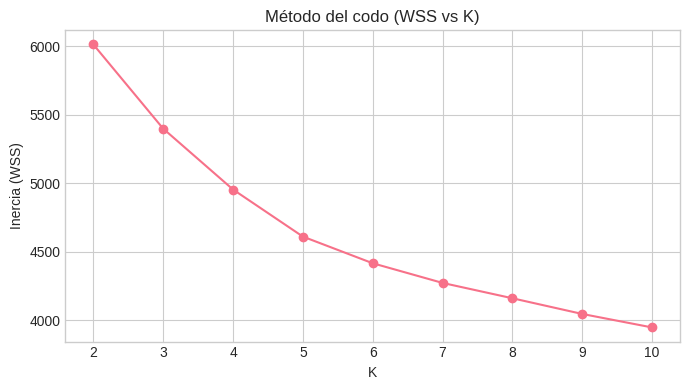

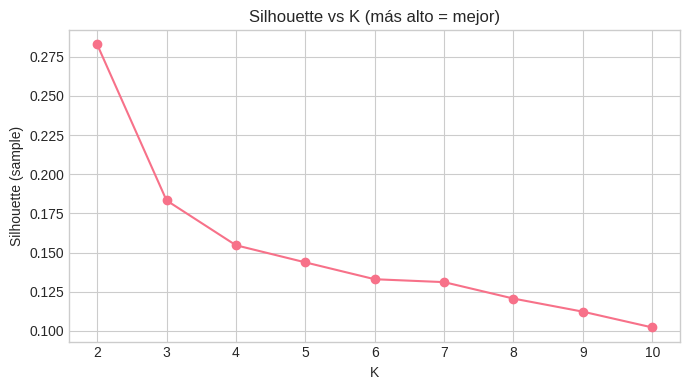

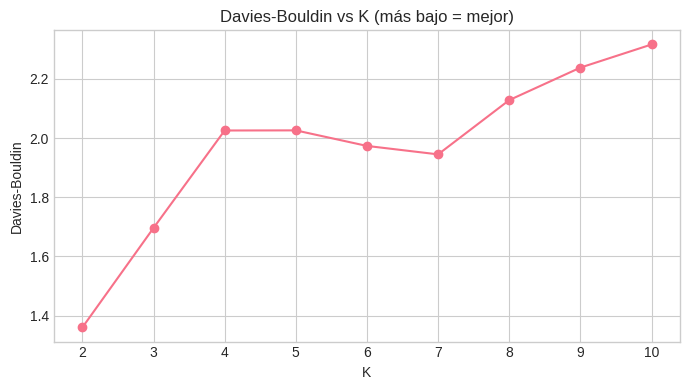

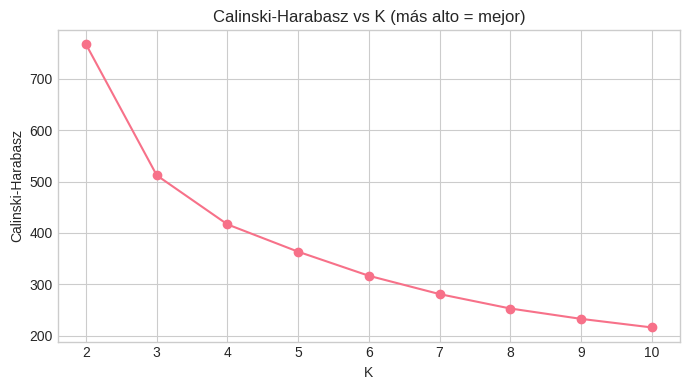

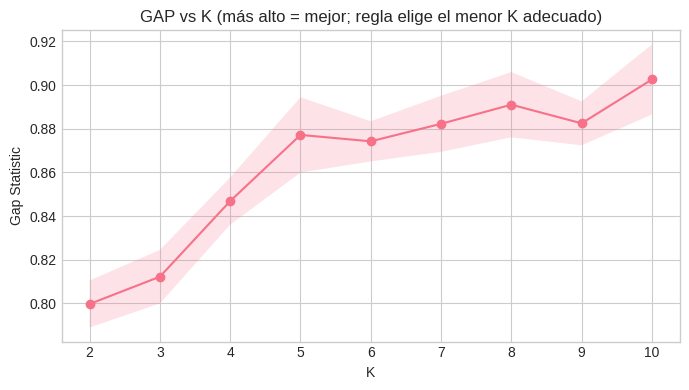

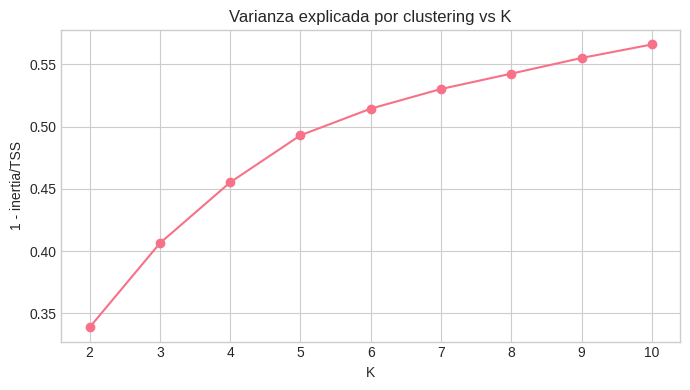

In [ ]:
# 10) BARRIDO DE K: (CODO + SILH + DB + CH + GAP)
ks = list(range(K_MIN, K_MAX + 1))

inertias = []
sil_scores = []
db_scores = []
ch_scores = []
explained = []  # 1 - inertia/TSS

# Para silhouette, usamos muestreo (más rápido)
idx_sil = _sample_rows(X_np, SAMPLE_SIZE_SILH, seed=RANDOM_STATE)

# TSS (total sum of squares) para “varianza explicada por clustering”
global_mean = X_np.mean(axis=0)
tss = np.sum((X_np - global_mean) ** 2)

for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
    labels = km.fit_predict(X_np)

    inertias.append(km.inertia_)
    explained.append(1 - km.inertia_ / tss)

    # silhouette (en sample)
    sil_scores.append(silhouette_score(X_np[idx_sil], labels[idx_sil]))

    # Davies-Bouldin (menor es mejor)
    db_scores.append(davies_bouldin_score(X_np, labels))

    # Calinski-Harabasz (mayor es mejor)
    ch_scores.append(calinski_harabasz_score(X_np, labels))

# GAP statistic
gaps, s_k = compute_gap_statistic(X_np, ks, B=GAP_B, sample_size=SAMPLE_SIZE_GAP, seed=RANDOM_STATE)
k_gap = choose_k_by_gap(ks, gaps, s_k)
k_sil = ks[int(np.argmax(sil_scores))]

print("\n=== Diagnóstico de K ===")
print(f"- K por GAP (regla de Tibshirani): {k_gap}")
print(f"- K por silhouette (máximo): {k_sil}")

# 10.1) Gráficas de métricas
plt.figure(figsize=(7,4))
plt.plot(ks, inertias, marker="o")
plt.xlabel("K")
plt.ylabel("Inercia (WSS)")
plt.title("Método del codo (WSS vs K)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(ks, sil_scores, marker="o")
plt.xlabel("K")
plt.ylabel("Silhouette (sample)")
plt.title("Silhouette vs K (más alto = mejor)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(ks, db_scores, marker="o")
plt.xlabel("K")
plt.ylabel("Davies-Bouldin")
plt.title("Davies-Bouldin vs K (más bajo = mejor)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(ks, ch_scores, marker="o")
plt.xlabel("K")
plt.ylabel("Calinski-Harabasz")
plt.title("Calinski-Harabasz vs K (más alto = mejor)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(ks, gaps, marker="o")
plt.fill_between(ks, gaps - s_k, gaps + s_k, alpha=0.2)
plt.xlabel("K")
plt.ylabel("Gap Statistic")
plt.title("GAP vs K (más alto = mejor; regla elige el menor K adecuado)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(ks, explained, marker="o")
plt.xlabel("K")
plt.ylabel("1 - inertia/TSS")
plt.title("Varianza explicada por clustering vs K")
plt.tight_layout()
plt.show()

In [ ]:

# 11) ESTABILIDAD POR BOOTSTRAP (VALIDACIÓN DE ROBUSTEZ)
def bootstrap_stability_ari(X_array, k, B=15, frac=0.8, seed=RANDOM_STATE):
    """
    Idea:
    - Ajustamos un KMeans base en todo X -> labels_base
    - Repetimos B veces: sample bootstrap parcial, ajustamos KMeans, predecimos labels en TODO X
    - Medimos similitud entre particiones con ARI (invariante a permutación de etiquetas)
    """
    rng = np.random.RandomState(seed)

    base = KMeans(n_clusters=k, random_state=seed, n_init=30)
    labels_base = base.fit_predict(X_array)

    aris = []
    n = X_array.shape[0]
    m = int(frac * n)

    for b in range(B):
        idx = rng.choice(n, size=m, replace=True)
        km = KMeans(n_clusters=k, random_state=seed + 1000 + b, n_init=10)
        km.fit(X_array[idx])

        labels_b = km.predict(X_array)  # asignación al modelo bootstrap
        aris.append(adjusted_rand_score(labels_base, labels_b))

    return float(np.mean(aris)), float(np.std(aris))

mean_ari_boot, std_ari_boot = bootstrap_stability_ari(X_np, k_gap, B=BOOT_B, frac=BOOT_FRAC)
print("\n=== Estabilidad Bootstrap (sobre K elegido por GAP) ===")
print(f"- ARI promedio vs base: {mean_ari_boot:.4f}  (std: {std_ari_boot:.4f})")


=== Estabilidad Bootstrap (sobre K elegido por GAP) ===
- ARI promedio vs base: 0.9192  (std: 0.0969)


In [ ]:
# 11) ESTABILIDAD POR BOOTSTRAP (VALIDACIÓN DE ROBUSTEZ con silhouette)
def bootstrap_stability_ari(X_array, k, B=15, frac=0.8, seed=RANDOM_STATE):
    """
    Idea:
    - Ajustamos un KMeans base en todo X -> labels_base
    - Repetimos B veces: sample bootstrap parcial, ajustamos KMeans, predecimos labels en TODO X
    - Medimos similitud entre particiones con ARI (invariante a permutación de etiquetas)
    """
    rng = np.random.RandomState(seed)

    base = KMeans(n_clusters=k, random_state=seed, n_init=30)
    labels_base = base.fit_predict(X_array)

    aris = []
    n = X_array.shape[0]
    m = int(frac * n)

    for b in range(B):
        idx = rng.choice(n, size=m, replace=True)
        km = KMeans(n_clusters=k, random_state=seed + 1000 + b, n_init=10)
        km.fit(X_array[idx])

        labels_b = km.predict(X_array)  # asignación al modelo bootstrap
        aris.append(adjusted_rand_score(labels_base, labels_b))

    return float(np.mean(aris)), float(np.std(aris))


# Ahora usamos K elegido por silhouette
mean_ari_boot, std_ari_boot = bootstrap_stability_ari(X_np, k_sil, B=BOOT_B, frac=BOOT_FRAC)

print("\n=== Estabilidad Bootstrap (sobre K elegido por silhouette) ===")
print(f"- ARI promedio vs base: {mean_ari_boot:.4f}  (std: {std_ari_boot:.4f})")


=== Estabilidad Bootstrap (sobre K elegido por silhouette) ===
- ARI promedio vs base: 0.9692  (std: 0.0151)


El K elegido por silhouette es mejor porque logra mayor estabilidad (ARI más alto) y menor variabilidad (std más bajo) en los bootstraps. Esto sugiere que la estructura de dos clusters es más sólida y reproducible


In [ ]:
# 12) ENTRENAMOS MODELO FINAL (AQUÍ FIJAMOS K)
# Recomendación práctica:
# - Si GAP sugiere un K mayor, pero silhouette prefiere K pequeño,
#   decide por: interpretabilidad + estabilidad + accionabilidad (campañas).
K_FINAL = k_sil   # puedes cambiar manualmente si tu negocio requiere otro K , k_sil, k_gap

kmeans = KMeans(n_clusters=K_FINAL, random_state=RANDOM_STATE, n_init=50)

# Se asigna a cada cliente un número de clúster
clientes["Cluster"] = kmeans.fit_predict(X_np)

print("\n=== Modelo final ===")
print(f"- K_FINAL = {K_FINAL}")
print("- Tamaño por cluster:")
print(clientes["Cluster"].value_counts().sort_index().to_string())


=== Modelo final ===
- K_FINAL = 2
- Tamaño por cluster:
Cluster
0    675
1    825


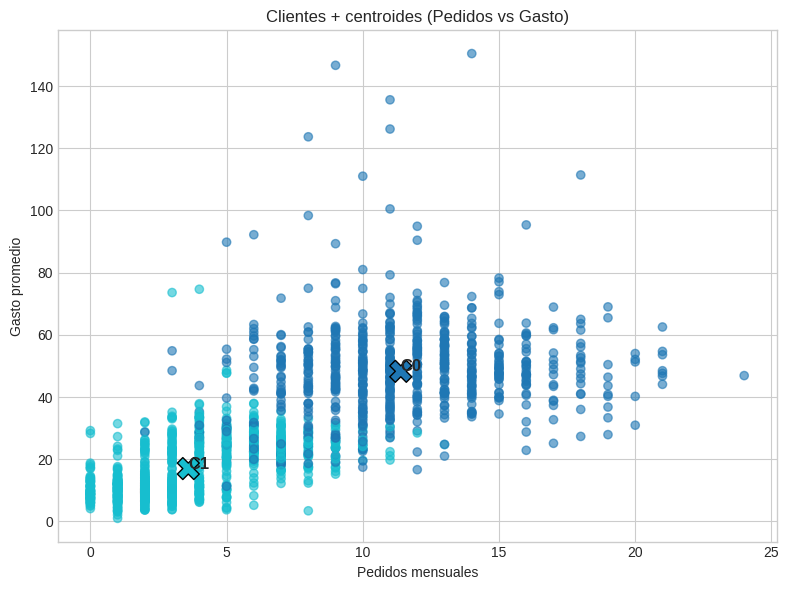

In [ ]:
# Plano interpretable: Pedidos vs Gasto + centroides (promedios en escala original)
plt.figure(figsize=(8,6))
plt.scatter(
    clientes["Pedidos_mensuales"], clientes["Gasto_promedio"],
    c=clientes["Cluster"], cmap="tab10", alpha=0.6
)

# centroides en color destacado
cent_2d = clientes.groupby("Cluster")[["Pedidos_mensuales", "Gasto_promedio"]].mean()
plt.scatter(
    cent_2d["Pedidos_mensuales"], cent_2d["Gasto_promedio"],
    marker="X", s=250, c=cent_2d.index, cmap="tab10", edgecolor="black")

# etiquetas de centroides
for k in cent_2d.index:
    plt.text(
        cent_2d.loc[k, "Pedidos_mensuales"],
        cent_2d.loc[k, "Gasto_promedio"],
        f"C{k}", fontsize=12, weight="bold"
    )

plt.xlabel("Pedidos mensuales")
plt.ylabel("Gasto promedio")
plt.title("Clientes + centroides (Pedidos vs Gasto)")
plt.tight_layout()
plt.show()


=== Chequeo externo (solo referencia conceptual) ===
- ARI(Perfil_latente, Cluster) = 0.5547
- NMI(Perfil_latente, Cluster) = 0.5906


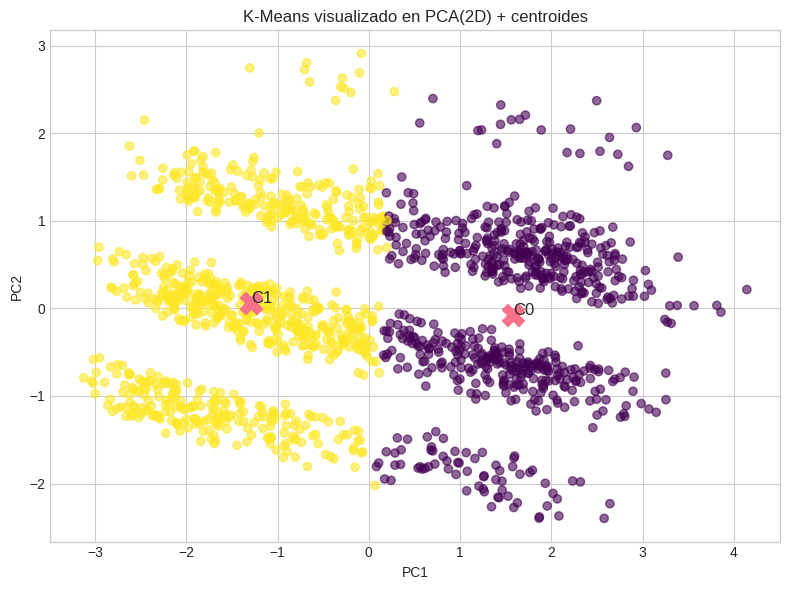

In [ ]:
# -----------------------------
# 13) VALIDACIÓN CON “PERFIL_LATENTE” (SI EXISTE COMO REFERENCIA)
# No es supervisado; esto solo es chequeo: ¿mis clusters se parecen a esa etiqueta conceptual?
ari_ref = adjusted_rand_score(clientes[REF_COL], clientes["Cluster"])
nmi_ref = normalized_mutual_info_score(clientes[REF_COL], clientes["Cluster"])

print("\n=== Chequeo externo (solo referencia conceptual) ===")
print(f"- ARI(Perfil_latente, Cluster) = {ari_ref:.4f}")
print(f"- NMI(Perfil_latente, Cluster) = {nmi_ref:.4f}")


# -----------------------------
# 14) VISUALIZACIÓN 2D (PCA) + CENTROIDES
# -----------------------------
# PCA aquí NO es para entrenar, solo para visualizar en 2D.
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca.fit_transform(X_np)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=clientes["Cluster"], cmap="viridis", alpha=0.6)

# Centroides en espacio original -> los proyectamos a PCA para ubicarlos en el plot
centroids_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], marker="X", s=250)

for k in range(K_FINAL):
    plt.text(centroids_2d[k,0], centroids_2d[k,1], f"C{k}", fontsize=12)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means visualizado en PCA(2D) + centroides")
plt.tight_layout()
plt.show()

In [ ]:
# 15) PERFILADO: RESUMEN INTERPRETABLE POR CLUSTER
def top_category(series, top_n=2):
    """Devuelve las categorías más frecuentes (como texto)"""
    vc = series.value_counts(normalize=True).head(top_n)
    parts = [f"{idx} ({val*100:.1f}%)" for idx, val in vc.items()]
    return ", ".join(parts)

# Estadísticos globales para comparar (baseline)
global_means = clientes[num_cols + ["Satisfaccion_1a5"]].mean(numeric_only=True)
global_stds  = clientes[num_cols + ["Satisfaccion_1a5"]].std(numeric_only=True).replace(0, 1)

# Construimos “tarjetas” de perfil (texto)
profiles = {}

for k in range(K_FINAL):
    sub = clientes[clientes["Cluster"] == k]

    # Medias numéricas (incluye binarias)
    means = sub[num_cols].mean(numeric_only=True)

    # Z-scores vs global (qué variables diferencian al cluster)
    # Se calculan las medias de las variables numéricas dentro del clúster
    z = (means - global_means[num_cols]) / global_stds[num_cols]
    # Se comparan con el promedio global mediante Z-scores
    top_pos = list(z.sort_values(ascending=False).head(3).index)
    top_neg = list(z.sort_values(ascending=True).head(3).index)

    # Categorías dominantes
    # Se identifican las categorías más frecuentes en variables cualitativas
    dom_region = top_category(sub["Region"], top_n=2)
    dom_canal  = top_category(sub["Canal"], top_n=2)
    dom_pago   = top_category(sub["Metodo_pago"], top_n=2)

    # Ordinales “de negocio” (en su forma original) - Se resumen variables clave
    dom_seg_edad = top_category(sub["Segmento_edad"], top_n=2)
    dom_fid      = top_category(sub["Nivel_fidelidad"], top_n=2)
    dom_riesgo   = top_category(sub["Riesgo_churn"], top_n=2)
    sat_mean     = sub["Satisfaccion_1a5"].mean()

    # Construccon de Perfil
    # Cada clúster se guarda en un diccionario con: Tamaño (n), Variables más altas y más bajas que el promedio,
    # Categorías dominantes y Satisfacción promedio.

    profiles[k] = {
        "n": len(sub),
        "means": means,
        "top_pos": top_pos,
        "top_neg": top_neg,
        "dom_region": dom_region,
        "dom_canal": dom_canal,
        "dom_pago": dom_pago,
        "dom_seg_edad": dom_seg_edad,
        "dom_fid": dom_fid,
        "dom_riesgo": dom_riesgo,
        "sat_mean": sat_mean }

# Interpretación final

print("\n=== Perfiles (resumen interpretativo) ===")
for k in range(K_FINAL):
    p = profiles[k]
    print(f"\n--- Cluster {k} | n={p['n']} ---")
    print("Variables MÁS altas que el promedio (top +):", ", ".join(p["top_pos"]))
    print("Variables MÁS bajas que el promedio (top -):", ", ".join(p["top_neg"]))
    print(f"Región dominante: {p['dom_region']}")
    print(f"Canal dominante: {p['dom_canal']}")
    print(f"Método de pago dominante: {p['dom_pago']}")
    print(f"Segmento edad dominante: {p['dom_seg_edad']}")
    print(f"Fidelidad dominante: {p['dom_fid']}")
    print(f"Riesgo churn dominante: {p['dom_riesgo']}")
    print(f"Satisfacción promedio: {p['sat_mean']:.2f}")


=== Perfiles (resumen interpretativo) ===

--- Cluster 0 | n=675 ---
Variables MÁS altas que el promedio (top +): Gasto_mensual_aprox, Pedidos_mensuales, Gasto_promedio
Variables MÁS bajas que el promedio (top -): Tiempo_promedio_entrega, Tuvo_devolucion, Edad
Región dominante: Lima (78.7%), Provincia (21.3%)
Canal dominante: App (54.5%), Web (39.1%)
Método de pago dominante: Tarjeta (56.4%), Billetera (24.0%)
Segmento edad dominante: 36-50 (49.0%), 26-35 (37.8%)
Fidelidad dominante: Platino (55.6%), Oro (41.0%)
Riesgo churn dominante: Bajo (62.8%), Medio (33.5%)
Satisfacción promedio: 2.48

--- Cluster 1 | n=825 ---
Variables MÁS altas que el promedio (top +): Tiempo_promedio_entrega, Tuvo_devolucion, Edad
Variables MÁS bajas que el promedio (top -): Gasto_mensual_aprox, Pedidos_mensuales, Gasto_promedio
Región dominante: Lima (56.2%), Provincia (43.8%)
Canal dominante: Web (40.4%), App (38.1%)
Método de pago dominante: Tarjeta (34.7%), Billetera (28.4%)
Segmento edad dominante: 26-3

# Implementacion de Vector Quantization (VQ)


In [ ]:
# Importaciones básicas para VQ y visualización
import numpy as np #  manejo de vectores/matrices.
import matplotlib.pyplot as plt #visualización.
import seaborn as sns # visualización.
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import requests #cargar imágenes desde la web
from PIL import Image #cargar imágenes desde la web
from io import BytesIO
import pandas as pd


warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [ ]:
# cargar el dataset Iris (150 flores, cada una con 4 atributos)
# Datos: 150 vectores ∈ ℝ⁴
iris = load_iris()
X = iris.data  # (150, 4)
print(f"Vectores a cuantizar: {X.shape}")

# Convertir a DataFrame para ver más claro
df_iris = pd.DataFrame(X, columns=iris.feature_names)
print(df_iris.head())


Vectores a cuantizar: (150, 4)
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


In [ ]:
# PASO 1 VQ: Entrenar diccionario K con kmeans 5
# K=5 prototipos,
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)  # Cada vector → código 0,1,2,3,4

# DICCIONARIO VQ: los centroides SON los códigos
codigos = kmeans.cluster_centers_  #  los centroides → el diccionario VQ con 5 prototipos
print("Diccionario VQ (5 códigos):\n", codigos.round(2))

Diccionario VQ (5 códigos):
 [[6.53 3.06 5.51 2.16]
 [5.01 3.43 1.46 0.25]
 [5.53 2.62 3.94 1.22]
 [6.23 2.85 4.77 1.57]
 [7.48 3.12 6.3  2.05]]


Cada fila es un “prototipo de flor” con medidas promedio

In [ ]:
# PASO 2 VQ: Reconstrucción (Cada flor original se sustituye por el centroide de su cluster)
reconstruccion = codigos[labels]  # Shape: (150, 4) RECUPERADO
# Esto es la compresión con pérdida: los datos originales se reemplazan por prototipos

# Error de cuantización
error_vq = np.mean(np.sum((X - reconstruccion)**2, axis=1))
print(f"Error cuantización VQ: {error_vq:.3f}")
print(f"Compresión: 150 vectores únicos → 5 códigos")

Error cuantización VQ: 0.310
Compresión: 150 vectores únicos → 5 códigos


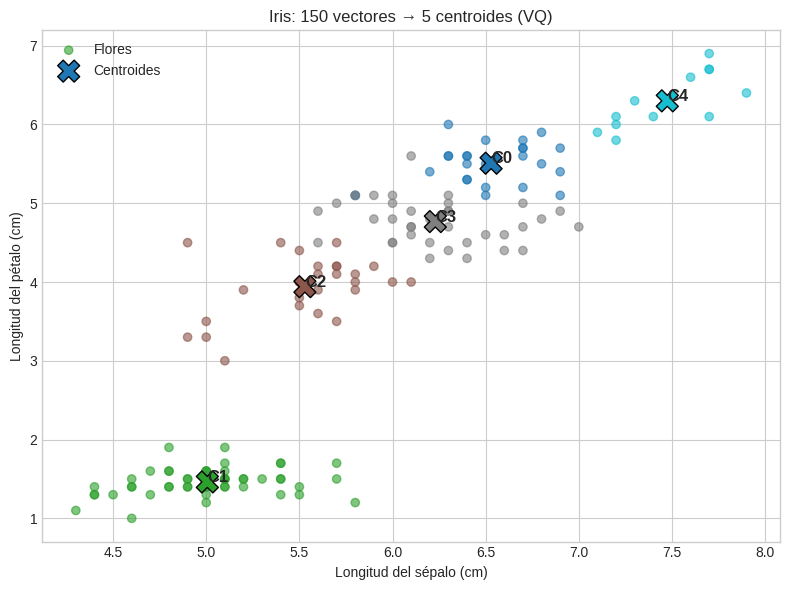

In [ ]:
# Usamos dos atributos para graficar: longitud del sépalo vs longitud del pétalo
plt.figure(figsize=(8,6))

# Puntos originales, coloreados por cluster asignado
plt.scatter(X[:,0], X[:,2], c=labels, cmap="tab10", alpha=0.6, label="Flores")

# Centroides (diccionario VQ con 5 códigos)
plt.scatter(codigos[:,0], codigos[:,2], marker="X", s=250, c=range(5), cmap="tab10", edgecolor="black", label="Centroides")

# Etiquetas de cada centroide
for i, centro in enumerate(codigos):
    plt.text(centro[0], centro[2], f"C{i}", fontsize=12, weight="bold")

plt.xlabel("Longitud del sépalo (cm)")
plt.ylabel("Longitud del pétalo (cm)")
plt.title("Iris: 150 vectores → 5 centroides (VQ)")
plt.legend()
plt.tight_layout()
plt.show()

# Salto a imágenes: misma técnica aplicada a otro tipo de vector

In [ ]:
# Imagen → matriz vectores RGB
# Salto a imágenes
url = "https://images.unsplash.com/photo-1541701494587-cb58502866ab?w=400"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('RGB') #se convierte a formato RGB

# La imagen se convierte en un arreglo NumPy

img_array = np.array(img, dtype=np.float32) / 255.0  # convierte la imagen a números en [0,1]

# ¡APLANAR! transformar la matriz 2D de píxeles en una lista 1D de vectores
# Antes: cada píxel estaba en una posición (fila, columna, canal)
pixels = img_array.reshape(-1, 3)  # Millones vectores ∈ ℝ³
h, w = img_array.shape[:2]
# Después: cada píxel es un vector de 3 valores (R, G, B) en una lista larga
print(f"Vectores píxeles: {pixels.shape}")

Vectores píxeles: (106800, 3)


* La imagen tiene 106800 píxeles (h×w).

* Cada píxel se vuelve un vector con 3 componentes: R (rojo), G (verde), B (azul).

In [ ]:
# VQ con K=16 colores (diccionario)
kmeans_img = KMeans(n_clusters=16, random_state=42, n_init=10)
# tendras 16 centroides, pero ahora cada centroide es un color prototipo
# random_state: fija la semilla del generador aleatorio
# se hacen 10 corridas independientes, y se elige la mejor según la inercia

labels_img = kmeans_img.fit_predict(pixels)  # Cada píxel → código 0-15
# fit_predict: entrena y devuelve directamente las etiquetas de cluster

# DICCIONARIO: 16 colores prototipo
paleta_rgb = kmeans_img.cluster_centers_  # (16, 3)
print(f"Diccionario VQ: {len(paleta_rgb)} códigos RGB")

Diccionario VQ: 16 códigos RGB


Cada píxel original (con miles de colores posibles)
se reemplaza por uno de esos 16 colores

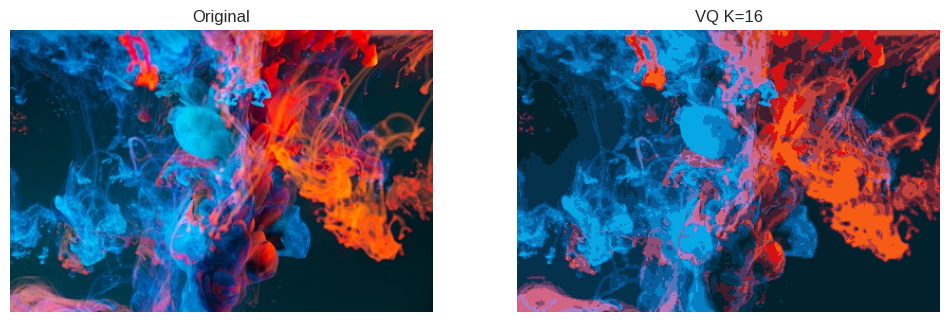

In [ ]:
# RECONSTRUCCIÓN VQ PÚRA
def reconstruir_vq(labels, codigos, height, width):
    """labels: códigos enteros, codigos: diccionario RGB"""
    return codigos[labels].reshape(height, width, 3) # convierte el mapa de etiquetas en una imagen reconstruida con los colores del diccionario
  # “Decodifica”: reemplaza cada label por el color del diccionario.
  #“Rearma” la imagen (alto×ancho×3).

# nueva imagen donde cada píxel original fue reemplazado por el color de su cluster:
img_vq = reconstruir_vq(labels_img, paleta_rgb, h, w)

# Visualizar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(img_array); ax1.set_title("Original"); ax1.axis('off')
ax2.imshow(img_vq); ax2.set_title("VQ K=16"); ax2.axis('off')
plt.show()

- La imagen original tenía millones de colores.
- Con VQ, cada píxel se sustituye por uno de los 16 colores del diccionario.

In [ ]:
Ks =[2]
diccionarios = {}

for k in Ks:
    print(f"VQ K={k}...")
    kmeans_k = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = kmeans_k.fit_predict(pixels)

    # Guardar diccionario + códigos
    diccionarios[k] = (labels_k, kmeans_k.cluster_centers_)

    # Error cuantización
    recon_k = kmeans_k.cluster_centers_[labels_k]
    error_k = np.mean(np.sum((pixels - recon_k)**2, axis=1))
    print(f"  Error VQ: {error_k:.4f}")

VQ K=2...
  Error VQ: 0.1016


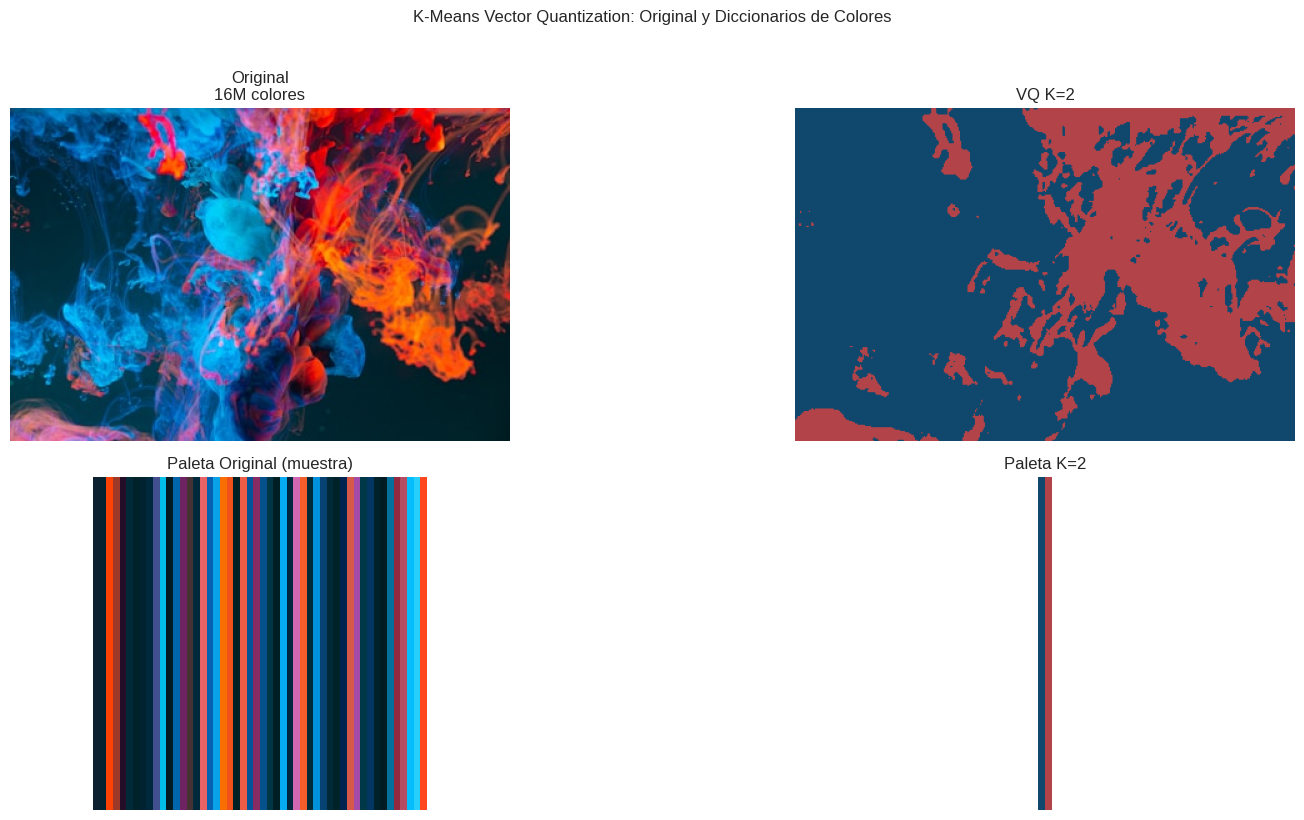

In [ ]:
# GALERÍA VQ: Original + Reconstrucciones con sus paletas
fig, axes = plt.subplots(2, len(Ks)+1, figsize=(18, 8))  # 2 filas: imagen y paleta
axes = axes.ravel()

# Columna 0: Imagen original y paleta original
axes[0].imshow(img_array)
axes[0].set_title("Original\n16M colores")
axes[0].axis('off')

# Paleta original (muestra de colores)
sample_size = 50
idx_sample = np.random.choice(pixels.shape[0], sample_size, replace=False)
paleta_orig = pixels[idx_sample]
paleta_orig_vis = np.repeat(paleta_orig[None, :, :], 50, axis=0)
axes[len(Ks)+1].imshow(paleta_orig_vis)
axes[len(Ks)+1].set_title("Paleta Original (muestra)")
axes[len(Ks)+1].axis('off')

# Columnas siguientes: cada K con su imagen y paleta
for i, k in enumerate(Ks):
    labels_k, paleta_k = diccionarios[k]
    img_k = reconstruir_vq(labels_k, paleta_k, h, w)

    # Imagen reconstruida (fila superior)
    axes[i+1].imshow(img_k)
    axes[i+1].set_title(f"VQ K={k}")
    axes[i+1].axis('off')

    # Paleta VQ (fila inferior)
    paleta_vis = np.repeat(paleta_k[None, :, :], 50, axis=0)
    axes[len(Ks)+i+2].imshow(paleta_vis)
    axes[len(Ks)+i+2].set_title(f"Paleta K={k}")
    axes[len(Ks)+i+2].axis('off')

plt.suptitle("K-Means Vector Quantization: Original y Diccionarios de Colores", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
def evaluar_vq(original_pixels, diccionarios):
    """PSNR y ratio compresión para cada diccionario"""
    resultados = []
    for k, (labels, codigos) in diccionarios.items():
        # Reconstrucción
        pixels_rec = codigos[labels]

        # PSNR (calidad VQ)
        mse = np.mean((original_pixels - pixels_rec)**2)
        psnr = 20 * np.log10(1/np.sqrt(mse)) if mse > 0 else 99

        # Compresión: colores únicos
        cols_orig = len(np.unique(original_pixels.round(2), axis=0))
        cols_vq = k
        ratio = cols_vq / cols_orig

        resultados.append((k, psnr, cols_orig, cols_vq, ratio))

    return resultados

# Evaluar
resultados = evaluar_vq(pixels, diccionarios)
print("K | PSNR ↑ | Colores Orig | Colores VQ | Ratio ↓")
print("-"*50)
for k, psnr, orig, vq, ratio in resultados:
    print(f"{k:2d} | {psnr:5.1f} | {orig:9,} | {vq:9,} | {ratio:.4f}")

K | PSNR ↑ | Colores Orig | Colores VQ | Ratio ↓
--------------------------------------------------
 2 |  14.7 |    45,092 |         2 | 0.0000


Saving paisajes-de-yosemite-46208063.webp to paisajes-de-yosemite-46208063.webp


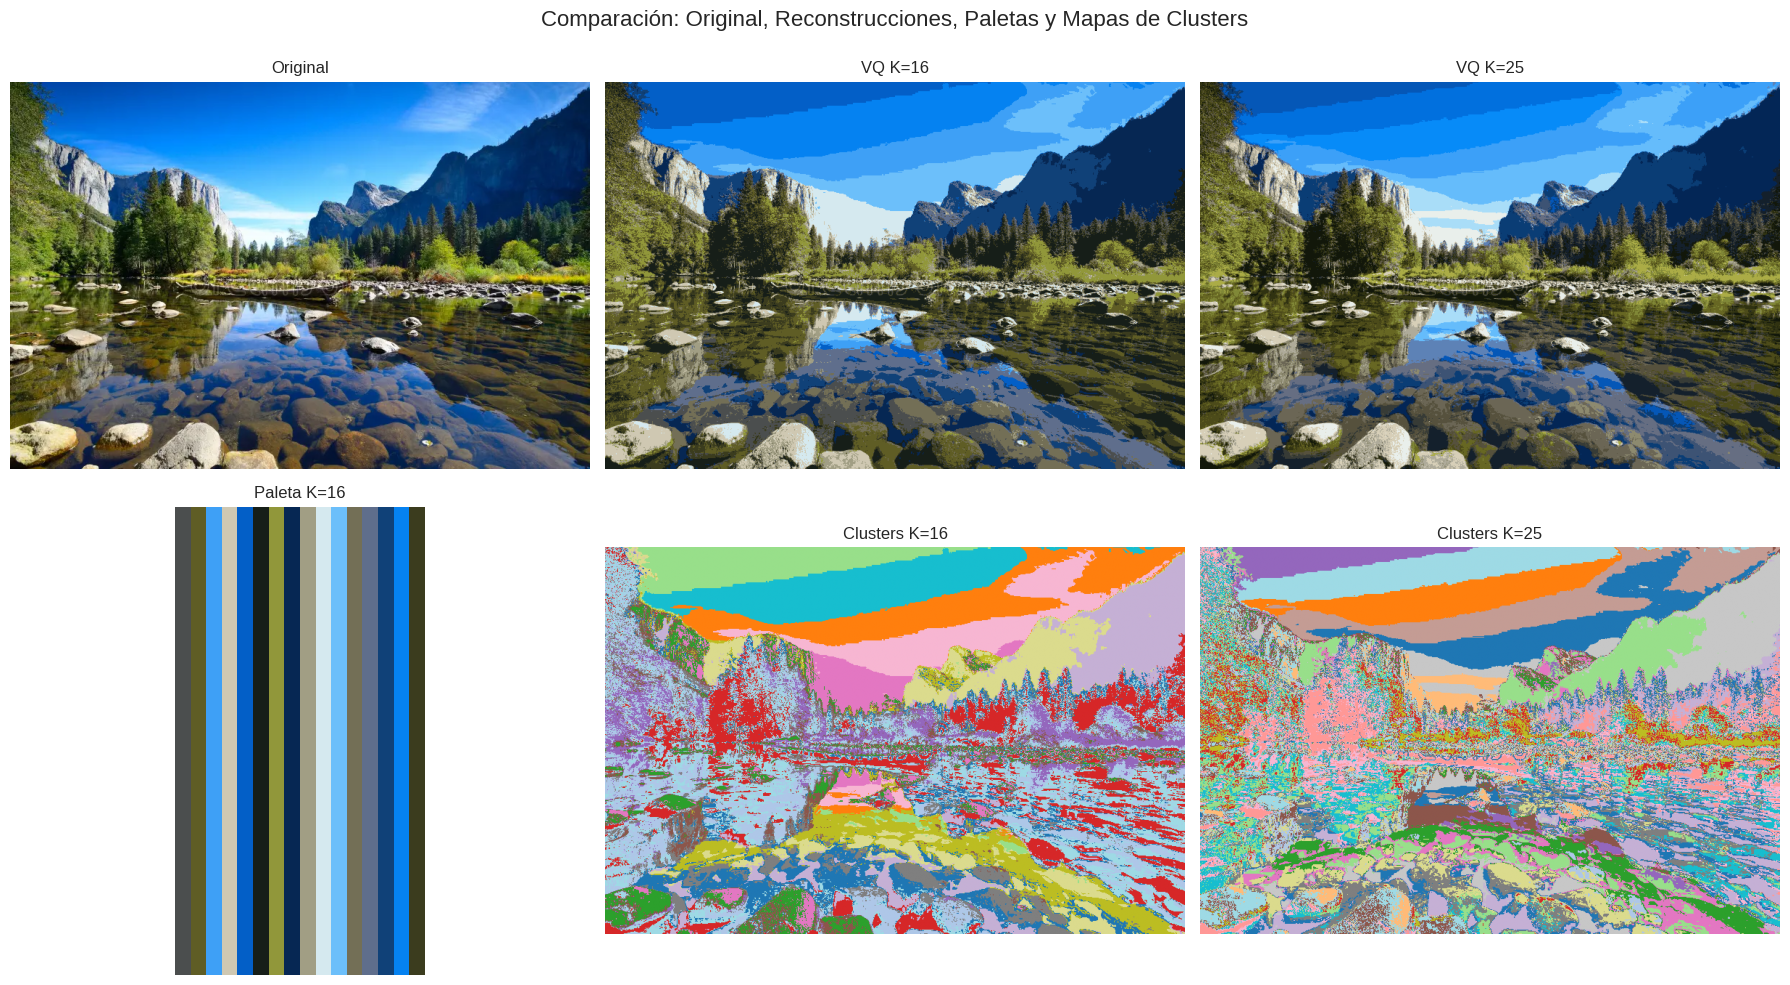

In [ ]:
# Subir imagen
uploaded = files.upload()
archivo = list(uploaded.keys())[0]  # primer archivo subido
mi_img = Image.open(archivo).convert('RGB')

# Procesar imagen
mi_array = np.array(mi_img, dtype=np.float32) / 255.0
mi_h, mi_w = mi_array.shape[:2]
mi_pixels = mi_array.reshape(-1, 3)

# Función para reconstruir imagen desde etiquetas y paleta
def reconstruir_vq(labels, paleta, h, w):
    return paleta[labels].reshape(h, w, 3)

# VQ con K=16 y K=25
kmeans16 = KMeans(n_clusters=16, random_state=42, n_init=10)
labels16 = kmeans16.fit_predict(mi_pixels)
paleta16 = kmeans16.cluster_centers_
vq16 = reconstruir_vq(labels16, paleta16, mi_h, mi_w)

kmeans25 = KMeans(n_clusters=25, random_state=42, n_init=10)
labels25 = kmeans25.fit_predict(mi_pixels)
paleta25 = kmeans25.cluster_centers_
vq25 = reconstruir_vq(labels25, paleta25, mi_h, mi_w)

# Mostrar resultados
labels16_img = labels16.reshape(mi_h, mi_w)
labels25_img = labels25.reshape(mi_h, mi_w)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Original
axes[0,0].imshow(mi_img)
axes[0,0].set_title("Original")
axes[0,0].axis('off')

# Reconstrucción K=16
axes[0,1].imshow(vq16)
axes[0,1].set_title("VQ K=16")
axes[0,1].axis('off')

# Reconstrucción K=25
axes[0,2].imshow(vq25)
axes[0,2].set_title("VQ K=25")
axes[0,2].axis('off')

# Paleta K=16
paleta16_vis = np.repeat(paleta16[None,:,:], 30, axis=0)
axes[1,0].imshow(paleta16_vis)
axes[1,0].set_title("Paleta K=16")
axes[1,0].axis('off')

# Etiquetas K=16 (mapa de clusters con colores)
axes[1,1].imshow(labels16_img, cmap='tab20')
axes[1,1].set_title("Clusters K=16")
axes[1,1].axis('off')

# Etiquetas K=25 (mapa de clusters con colores)
axes[1,2].imshow(labels25_img, cmap='tab20')
axes[1,2].set_title("Clusters K=25")
axes[1,2].axis('off')

plt.suptitle("Comparación: Original, Reconstrucciones, Paletas y Mapas de Clusters", fontsize=16)
plt.tight_layout()
plt.show()